In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
import joblib
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("train.csv")
print(df.shape)
print(df.columns.tolist())
print(df.head(2))

(909604, 16)
['timestamp', 'active_power_calculated_by_converter', 'active_power_raw', 'ambient_temperature', 'generator_speed', 'generator_winding_temp_max', 'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp', 'reactice_power_calculated_by_converter', 'reactive_power', 'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence', 'turbine_id', 'Target']
             timestamp  active_power_calculated_by_converter  \
0  2021-02-19 20:18:00                            816.636759   
1  2021-04-27 04:55:00                            419.107829   

   active_power_raw  ambient_temperature  generator_speed  \
0        834.917206            31.694380      1159.616602   
1        421.050873            12.894948       928.747996   

   generator_winding_temp_max  grid_power10min_average  nc1_inside_temp  \
0                   65.954214               917.897085        31.881972   
1                   59.571319               445.554250        32.423705   

   nacelle_temp  reactice_p

In [4]:
target = "Target"
y = df[target]
X = df.drop(columns=[target])


In [5]:
print(df.head(2))
print("Target sample:", y.head(3))


             timestamp  active_power_calculated_by_converter  \
0  2021-02-19 20:18:00                            816.636759   
1  2021-04-27 04:55:00                            419.107829   

   active_power_raw  ambient_temperature  generator_speed  \
0        834.917206            31.694380      1159.616602   
1        421.050873            12.894948       928.747996   

   generator_winding_temp_max  grid_power10min_average  nc1_inside_temp  \
0                   65.954214               917.897085        31.881972   
1                   59.571319               445.554250        32.423705   

   nacelle_temp  reactice_power_calculated_by_converter  reactive_power  \
0     31.504713                              141.457644      165.501518   
1     32.755770                               89.186457      113.835236   

   wind_direction_raw  wind_speed_raw  wind_speed_turbulence   turbine_id  \
0          280.864782        7.057000               0.544082  Turbine_108   
1          299.55

In [6]:
# 3️⃣ Feature engineering
# --- Time-based ---
X["timestamp"] = pd.to_datetime(X["timestamp"], errors="coerce")
X["hour"] = X["timestamp"].dt.hour
X["dayofyear"] = X["timestamp"].dt.dayofyear
X["hour_sin"] = np.sin(2 * np.pi * X["hour"] / 24)
X["hour_cos"] = np.cos(2 * np.pi * X["hour"] / 24)
X["day_sin"] = np.sin(2 * np.pi * X["dayofyear"] / 365)
X["day_cos"] = np.cos(2 * np.pi * X["dayofyear"] / 365)

# --- Physics-based ---
X["wind_speed_sq"] = X["wind_speed_raw"] ** 2
X["wind_speed_cu"] = X["wind_speed_raw"] ** 3
X["power_coefficient"] = X["active_power_raw"] / (X["wind_speed_raw"]**3 + 1e-6)

# --- Thermal / efficiency ---
X["temp_diff_nacelle_ambient"] = X["nacelle_temp"] - X["ambient_temperature"]
X["temp_diff_generator_ambient"] = X["generator_winding_temp_max"] - X["ambient_temperature"]
X["avg_internal_temp"] = (X["nacelle_temp"] + X["nc1_inside_temp"]) / 2

# --- Interaction features ---
X["wind_times_gen"] = X["wind_speed_raw"] * X["generator_speed"]
X["wind_temp_ratio"] = X["wind_speed_raw"] / (X["ambient_temperature"] + 273.15)

# --- Turbine encoding ---
X["turbine_id"] = X["turbine_id"].astype(str)
X["turbine_code"] = pd.factorize(X["turbine_id"])[0]

# Drop raw timestamp column (we extracted features)
X = X.drop(columns=["timestamp"])

print("🔧 Features after engineering:", len(X.columns))

🔧 Features after engineering: 29


In [7]:
# 4️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (727683, 29) Test: (181921, 29)


In [8]:
# 5️⃣ Preprocessing pipelines
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='__missing__')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
], remainder='drop', sparse_threshold=0)

In [9]:
def make_pipeline(model):
    return Pipeline([('preproc', preprocessor), ('model', model)])

In [10]:
from lightgbm import LGBMRegressor

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor  # ✅ import XGBoost

# Define models
hgb = HistGradientBoostingRegressor(
    max_iter=300,
    max_depth=12,
    learning_rate=0.1,
    random_state=42
)

lr = LinearRegression()

lgbm = LGBMRegressor(
    n_estimators=300,
    max_depth=12,
    learning_rate=0.1,
    random_state=42
)

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=12,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Dictionary of models to train
models = {
    "LinearRegression": lr,
    "HistGradientBoosting": hgb,
    "LightGBM": lgbm,
    "XGBoost": xgb  # ✅ added XGBoost model
}



🚀 Training LinearRegression ...
LinearRegression → RMSE=1.6604, MAE=1.1619, R2=0.5963, CV_RMSE=1.6652, CV_R2=0.5957


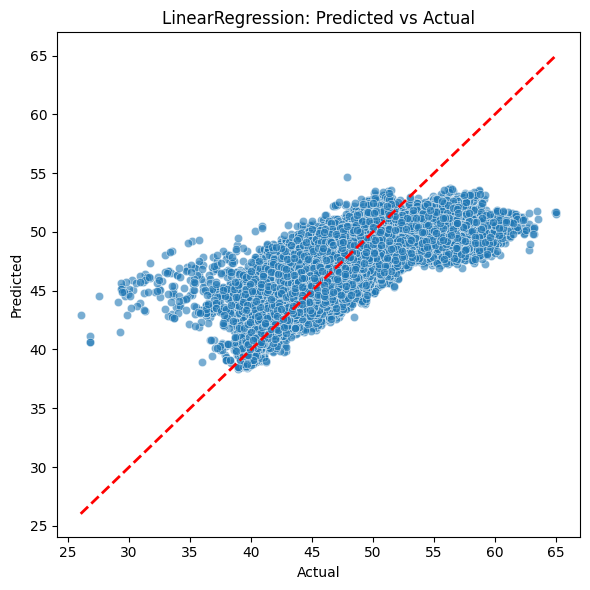

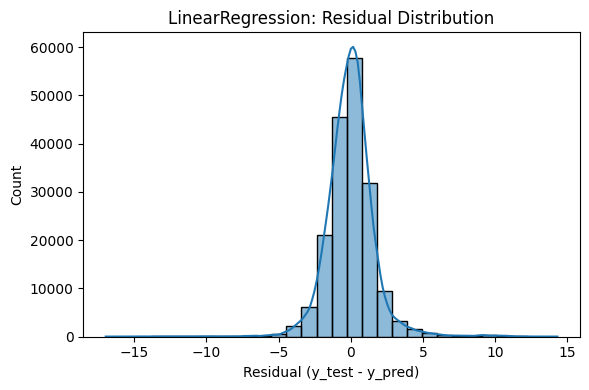


🚀 Training HistGradientBoosting ...
HistGradientBoosting → RMSE=0.7164, MAE=0.5303, R2=0.9248, CV_RMSE=0.7231, CV_R2=0.9237


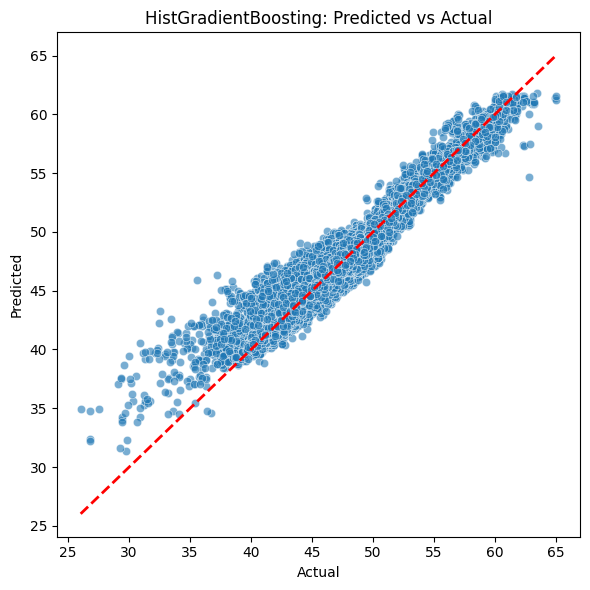

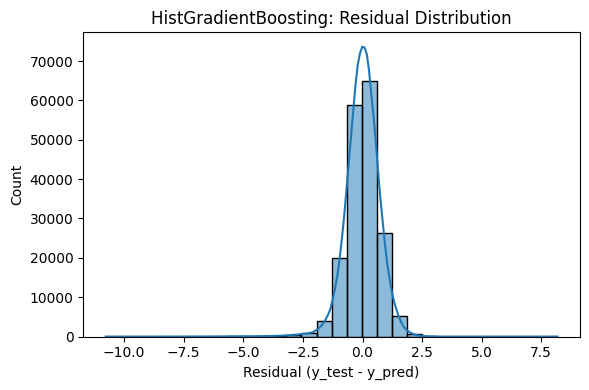


🚀 Training LightGBM ...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6196
[LightGBM] [Info] Number of data points in the train set: 727683, number of used features: 44
[LightGBM] [Info] Start training from score 46.329379
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6196
[LightGBM] [Info] Number of data points in the train set: 582146, number of used features: 44
[LightGBM] [Info] Start training from score 46.331558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6197
[LightGBM] [Info] Number of data points in the train set: 582146, number of used features: 

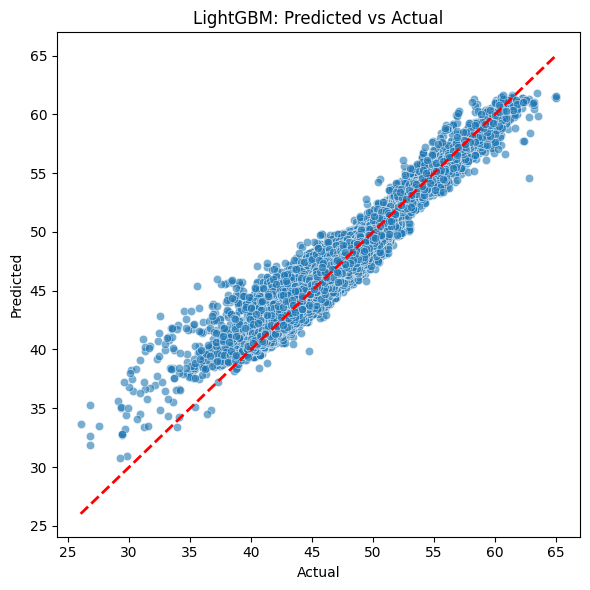

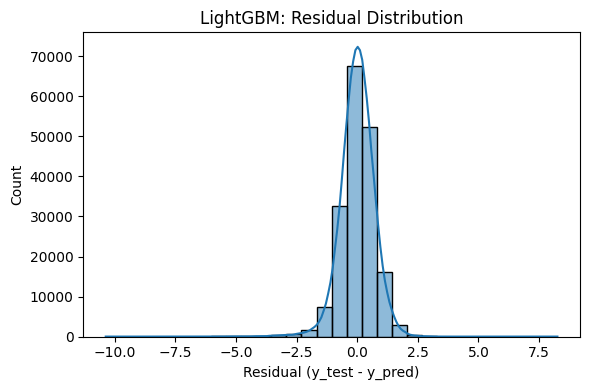


🌲 Top features for LightGBM:
dayofyear                     1615
day_sin                       1168
day_cos                        796
turbine_code                   550
hour                           412
ambient_temperature            370
generator_winding_temp_max     368
nacelle_temp                   318
temp_diff_nacelle_ambient      309
wind_direction_raw             254
dtype: int32


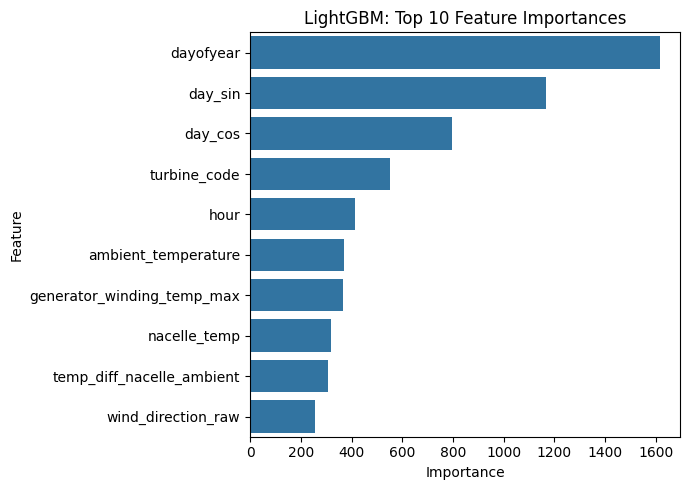


🚀 Training XGBoost ...
XGBoost → RMSE=0.2962, MAE=0.2131, R2=0.9872, CV_RMSE=0.3129, CV_R2=0.9857


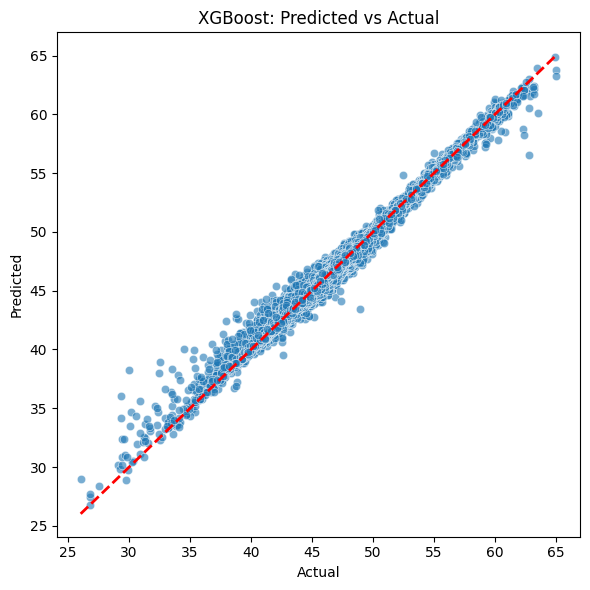

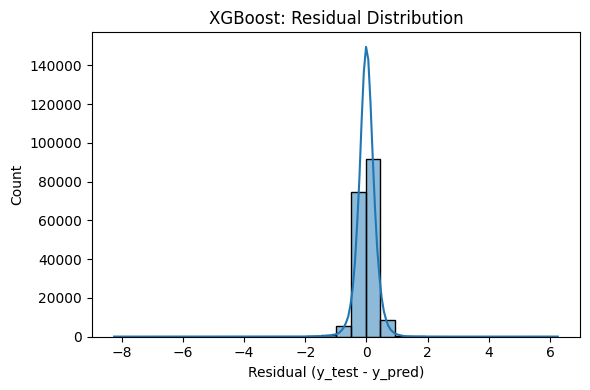


🌲 Top features for XGBoost:
turbine_id_Turbine_01     0.335542
turbine_id_Turbine_20     0.198842
turbine_id_Turbine_105    0.070424
day_cos                   0.064301
turbine_code              0.046821
turbine_id_Turbine_18     0.040311
turbine_id_Turbine_14     0.033586
turbine_id_Turbine_13     0.031232
nacelle_temp              0.021053
dayofyear                 0.020682
dtype: float32


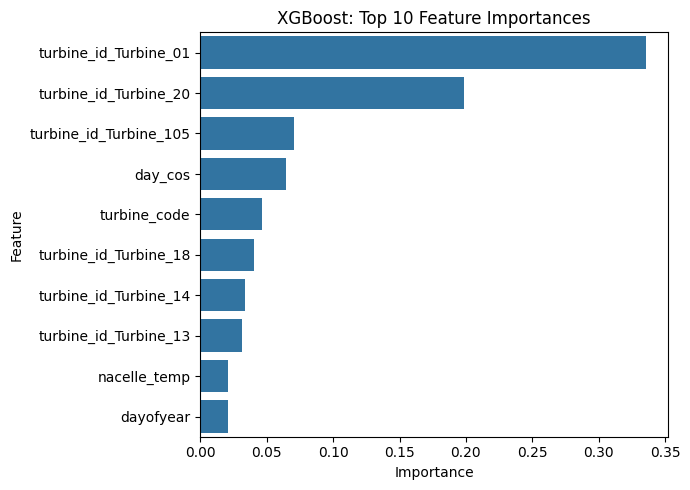


📊 Model Performance Summary:


,RMSE,MAE,MedianAE,MAPE (%),R2,CV_RMSE,CV_R2
XGBoost,0.296162,0.213096,0.161245,0.462328,0.987156,0.312865,0.985722
LightGBM,0.715268,0.530103,0.422307,1.152583,0.925082,0.717300,0.924969
HistGradientBoosting,0.716406,0.530259,0.421113,1.152966,0.924844,0.723145,0.923738
LinearRegression,1.660381,1.161946,0.863793,2.487691,0.596296,1.665198,0.595666


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Identify categorical and numeric columns ---
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['number']).columns

# Initialize dictionaries
results = {}
trained_pipes = {}

for name, model in models.items():
    print(f"\n🚀 Training {name} ...")

    # --- Create pipeline with preprocessing ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ]
    )

    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # --- Fit and predict ---
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # --- Metrics ---
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # --- Cross-validation (5-fold) ---
    try:
        cv_r2 = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()
        cv_rmse = (-cross_val_score(pipe, X_train, y_train, cv=5,
                                    scoring='neg_root_mean_squared_error')).mean()
    except:
        cv_r2 = np.nan
        cv_rmse = np.nan

    # --- Store results ---
    results[name] = {
        "RMSE": rmse,
        "MAE": mae,
        "MedianAE": medae,
        "MAPE (%)": mape,
        "R2": r2,
        "CV_RMSE": cv_rmse,
        "CV_R2": cv_r2
    }
    trained_pipes[name] = pipe

    print(f"{name} → RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}, CV_RMSE={cv_rmse:.4f}, CV_R2={cv_r2:.4f}")

    # --- Plot: Predicted vs Actual ---
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name}: Predicted vs Actual")
    plt.tight_layout()
    plt.show()

    # --- Plot: Residual Distribution ---
    residuals = y_test - y_pred
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{name}: Residual Distribution")
    plt.xlabel("Residual (y_test - y_pred)")
    plt.tight_layout()
    plt.show()

    # --- Feature Importance (Tree-based models only) ---
    if name != "LinearRegression":
        model_in_pipe = pipe.named_steps['regressor']
        if hasattr(model_in_pipe, "feature_importances_"):
            # Get feature names after one-hot encoding
            feature_names = list(numeric_cols)
            if len(categorical_cols) > 0:
                cat_features = pipe.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
                feature_names += list(cat_features)

            importances = model_in_pipe.feature_importances_
            feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

            print(f"\n🌲 Top features for {name}:")
            print(feature_importance.head(10))

            plt.figure(figsize=(7,5))
            sns.barplot(x=feature_importance.head(10), y=feature_importance.head(10).index)
            plt.title(f"{name}: Top 10 Feature Importances")
            plt.xlabel("Importance")
            plt.ylabel("Feature")
            plt.tight_layout()
            plt.show()

# --- Summary Table ---
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")
print("\n📊 Model Performance Summary:")
display(results_df)


index,RMSE,MAE,MedianAE,MAPE (%),R2,CV_RMSE,CV_R2
XGBoost,0.29616230644315944,0.21309559031242065,0.16124534606935725,0.4623276992741849,0.9871558046054589,0.31286473344025884,0.9857221234868534
LightGBM,0.7152675160156355,0.530102546294745,0.4223072623723638,1.152583156621514,0.9250823164773113,0.7172996747272309,0.9249694043817808
HistGradientBoosting,0.7164064792114565,0.5302593128972738,0.4211133979062822,1.152965872900849,0.9248435347092095,0.7231445136405605,0.9237377758633091
LinearRegression,1.660381087206099,1.1619461700234102,0.8637928093938356,2.487690861601075,0.5962961490349661,1.6651979043659417,0.5956658224469157